# Part 3: Advanced Text Processing - LDA and BERTopic Topic Modeling (20 pts)

## Basic Imports

In [35]:
from spacy import displacy
import spacy
from bertopic import BERTopic
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.gensim_models
import numpy as np
import pandas as pd

## 3.1 Preprocessing for Topic Modeling

We load the dataset, apply spaCy to tokenize and lemmatize text, and construct a list of lemma tokens for each document. Stop words, punctuation, and whitespace tokens are removed to prepare clean inputs for topic modeling.

In [36]:
nlp = spacy.load("en_core_web_sm")
sou = pd.read_csv("data/SOTU.csv")

def preprocess_text(text): 
    doc = nlp(text) 
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space and len(token.lemma_) > 3]

processed_docs = sou['Text'].apply(preprocess_text)

## 3.2 LDA Topic Modeling

We construct a dictionary and bag-of-words corpus from the lemma lists.
Using Gensim’s LDA model, we extract a set of topics from the entire SOTU speech collection.

In [37]:
dictionary = Dictionary(processed_docs)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=18, random_state=42, passes=10)

lda_topics = lda_model.print_topics(num_words=10)
print("---LDA Topics---")
for idx, topic in lda_model.print_topics(-1): 
    print(f"Topic: {idx} \nWords: {topic}\n")

---LDA Topics---
Topic: 0 
Words: 0.004*"cent" + 0.004*"june" + 0.004*"gold" + 0.003*"island" + 0.003*"silver" + 0.003*"bond" + 0.003*"method" + 0.003*"convention" + 0.003*"indian" + 0.003*"note"

Topic: 1 
Words: 0.008*"depression" + 0.007*"program" + 0.007*"recovery" + 0.006*"budget" + 0.006*"unemployment" + 0.006*"loan" + 0.006*"activity" + 0.006*"farm" + 0.005*"emergency" + 0.005*"cent"

Topic: 2 
Words: 0.008*"dictator" + 0.005*"expression" + 0.004*"british" + 0.004*"1914" + 0.003*"impressive" + 0.003*"actual" + 0.003*"revolution" + 0.003*"schedule" + 0.003*"continent" + 0.003*"partisanship"

Topic: 3 
Words: 0.008*"forest" + 0.007*"corporation" + 0.005*"judge" + 0.005*"wrong" + 0.005*"interstate" + 0.004*"employee" + 0.003*"bureau" + 0.003*"body" + 0.003*"mountain" + 0.003*"island"

Topic: 4 
Words: 0.017*"program" + 0.014*"soviet" + 0.009*"1980" + 0.009*"u.s." + 0.008*"area" + 0.007*"major" + 0.006*"goal" + 0.006*"commitment" + 0.006*"challenge" + 0.006*"nuclear"

Topic: 5 
Word

In [38]:
first_doc_bow = corpus[0]
first_doc_topics = lda_model.get_document_topics(first_doc_bow)

print(first_doc_topics)

[(11, np.float32(0.99942815))]


In [39]:
pyLDAvis.enable_notebook()

lda_vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
lda_vis

pyLDAvis.save_html(lda_vis, 'outputs/P03_figure_1.html')

## LDA Topic Interpretation

The LDA topics generally capture high-frequency, surface-level themes in the corpus.
Common words such as government, year, world, nation, states, congress appear across many topics, showing that LDA groups speeches based on repeated vocabulary patterns rather than semantic meaning.
Because SOTU speeches share strong stylistic overlap, the LDA topics tend to be broad and partially overlapping.

## 3.3 BERTopic Modeling

We further apply BERTopic, which uses transformer embeddings and density-based clustering to form semantically coherent clusters.

In [40]:
docs = sou["Text"].to_list()

In [41]:
import umap

umap_model = umap.UMAP(random_state=42)

topic_model = BERTopic(min_topic_size=3, umap_model=umap_model, calculate_probabilities=True)
topics, probs = topic_model.fit_transform(docs)

vectorizer_model = CountVectorizer(stop_words="english")
topic_model.update_topics(docs, vectorizer_model=vectorizer_model)

In [42]:
topic_info = topic_model.get_topic_info()
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,73,-1_government_states_congress_year,"[government, states, congress, year, united, p...",[\nTo the Senate and House of Representatives:...
1,0,22,0_states_government_united_congress,"[states, government, united, congress, public,...",[\nFellow-Citizens of the Senate and of the Ho...
2,1,15,1_states_government_united_congress,"[states, government, united, congress, departm...",[\nFellow-Citizens of the Senate and House of ...
3,2,13,2_america_world_new_years,"[america, world, new, years, american, people,...","[\nMr. Speaker, Mr. President, my colleagues i..."
4,3,12,3_states_government_united_congress,"[states, government, united, congress, public,...",[\nFellow-Citizens of the Senate and of the Ho...
5,4,11,4_world_new_economic_program,"[world, new, economic, program, federal, years...","[\nMr. President, Mr. Speaker, Members of the ..."
6,5,11,5_world_nations_soviet_peace,"[world, nations, soviet, peace, economic, nati...","[\nMr. President, Mr. Speaker, Members of the ..."
7,6,9,6_government_states_law_united,"[government, states, law, united, congress, go...",[\nTo the Senate and House of Representatives:...
8,7,9,7_government_great_work_law,"[government, great, work, law, public, nationa...",[\nTo the Senate and House of Representatives:...
9,8,7,8_states_united_government_constitution,"[states, united, government, constitution, con...",[\nTo the Senate and House of Representatives:...


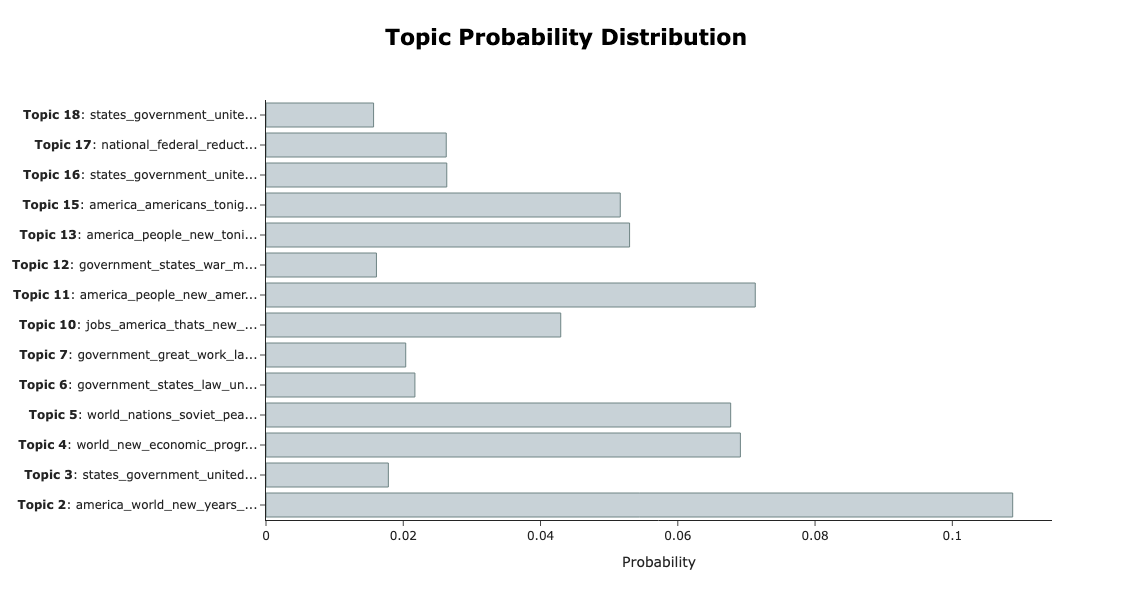

In [43]:
first_probs = probs[0]
fig = topic_model.visualize_distribution(first_probs)
fig.show()

fig.write_html("outputs/P03_figure_2.html")

In [44]:
fig2 = topic_model.visualize_topics()
fig2.show()

fig2.write_html("outputs/P03_figure_3.html")

## BERTopic Topic Interpretation

BERTopic typically produces fewer, more semantically distinct topics.
Because transformer embeddings capture contextual meaning, the model groups speeches into broader conceptual clusters such as:

- Government/Congress/National Affairs

- America/People/World/Future Themes

This reflects semantic coherence, contrasting with LDA’s frequency-driven clustering.

## 3.4 Comparison: LDA vs BERTopic

- LDA uses a bag-of-words representation and identifies topics based on word co-occurrence.
   <br>→ Produces several overlapping topics with similar vocabulary.

- BERTopic uses sentence-level semantic embeddings from transformers.
   <br>→ Produces fewer, but more meaningful and interpretable clusters.

- Since SOTU speeches share structure and vocabulary,
   <br>→ LDA tends to fragment content into many similar topics,
   <br>→ BERTopic groups documents by broader themes reflecting actual meaning.

Overall, BERTopic provides more coherent high-level topics, while LDA gives granular but noisy lexical clusters.